In [22]:
import os,sys,netCDF4

# Get dir name of parent directory
modfol=os.path.dirname(os.getcwd())
sys.path.insert(0, modfol)

# Complete import statements 
import GeneralFunctions as GF, numpy as np, matplotlib.pyplot as plt, pandas as pd

# Set Data directory
datadir=modfol+"/Data/"

# Setname of observations file
obsfile=datadir+"Pyramid_SCol.xlsx" # Sheetnames = "Pyramid_hour"; "SCol"


# Comparison of Daily Observations and Reanalysis Data

### Station Observations
First we import the weather station data. These data have a temporal frequency of 10 minutes, and are in Nepali time (GMT+5:45). We import into a pandas DataFrame and set the Date (first column) as the time index. We also convert to daily and drop the first obs (incomplete day)

In [48]:
obs=pd.read_excel(obsfile,sheet_name="SCol",index_col=0,parse_dates=True,names=["Temp_Obs","Press_Obs"])
obs.index =obs.index+pd.DateOffset(hours=-5.75) # note that we convert to UTC
#obs.tail(5) # <- uncomment to examine
obs_daily=(obs.resample("D").mean())[1:]
#obs_daily.head(5) # <- ditto

### Reanalysis Data
Next we iterate over all the monthly NetCDF files, (bi-linearly) interpolating to the lon (86.9250) and lat (27.9878) of Everest, and to the elevation of the South Col (7986 m). These interpolated data are inserted into a time-aware Pandas DataFrame. 

In [68]:
# To facilitate the interpolation, we write a convenience function that interpolates horizontally using the system
# install of CDO. We then interpolate vertically using Python

def interpNC(fin,zname,pname,tname,low_p,high_p,z_c):

    """
    Take variables in fin -- which is time/plevel netCDF4 Dataset and 
    interpolate to the z of interest
    
    fin   :-> netCDF4 input file
    zname :-> name of geopotential height variable
    pname :-> name of pressure level variable
    tname :-> name of temperature variable
    low_p :-> Pressure (in Pa) of surface above Everest
    high_p:-> Pressue (in Pa) of surface below South Col
    z_c   :-> height to interpolate to
    
    """
    
    # Interpolate entire file (i.e. all vars/times) horizontally with CDO 
    cmd="cdo remapbil,lon=86.93333_lat=27.96667 %s%s /tmp/scratch.nc" % (datadir,fin)
    fail=os.system(cmd); assert fail==0,"This call failed:\n%s"%cmd # system call
    
    # recycle fin to be the netCDF file
    fin=netCDF4.Dataset("/tmp/scratch.nc")
    
    # Variables for interpolation
    vs=[ii for ii in fin.variables if "lon" not in ii and "lat" not in ii and\
        "time" not in ii and zname not in ii and "z" not in ii]
    
    #Assignments and preallocation
    z=np.squeeze(fin.variables[zname][:,:]) # Height - m
    temp=np.squeeze(fin.variables[tname][:,:]) # Temp - K
    p=np.squeeze(fin.variables[pname][:]) # Pressure level 
    time=fin.variables["time"] # Time
    nt=len(time)
    nv=len(vs)
    tcount=range(nt)
    vcount=range(nv)
    out=np.zeros((len(time),len(vs)+1))*np.nan # 
    ptime=netCDF4.num2date(time[:],units=time.units,calendar=time.calendar)  

    
    # Main loop 
    for v in vcount: # Over variables
        y=np.squeeze(fin.variables[vs[v]][:])
        for t in tcount: # Over time
            if vs[v]=="level":
               out[t,v]= np.interp(z_c,z[t,::-1],p[::-1])
            else:
                out[t,v]=np.interp(z_c,z[t,::-1],y[t,::-1])    
                           
        if vs[v]=="t": # convert to deg C
            out[:,v]-=273.15
      
    # Add lapse rate (degC/km)        
    out[:,-1]=np.squeeze((temp[:,p==low_p]-temp[:,p==high_p])/\
    (z[:,p==low_p]-z[:,p==high_p]))*1e3
    
    return pd.DataFrame(data=out,columns=vs+["lapse"],index=ptime)

# Here, we list all the netCDF4 files to interpolate...
files=[ii for ii in os.listdir(datadir) if ".nc" in ii]

# And now we apply the interpolation routine (function) to all monthly files -- merging the output into a Pandas DF...
# [Note: this code is quite slow at the moment!]
mod=pd.concat([interpNC(files[ii],"z_2","level","t",300,400,7986) for ii in range(len(files))])

In [69]:
# Now we compute the daily mean for the reanalysis data (new cell is because the previous one is slow to run!)
mod_daily=mod.resample("D").mean()

### Comparing Observations and Reanalysis Data
Here we combine the two dataframes and examine the agreement between series

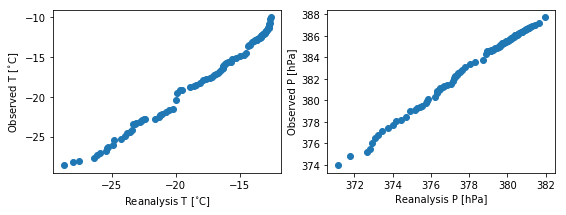

In [91]:
comb=(pd.concat([obs_daily,mod_daily],axis=1)).dropna()
# Temporal agreement between Temp and Pressure?
r_t=np.corrcoef(comb["Temp_Obs"],comb["t"])[0,1]
r_p=np.corrcoef(comb["Press_Obs"],comb["level"])[0,1]
# Quantile agreement?
pcs=np.arange(1,100,1)
qs=pd.DataFrame(data=np.percentile(comb,pcs,axis=0),columns=comb.columns,index=pcs)
# Plot the quantile agreement 
fig,ax=plt.subplots(1,2)
# Temp
ax.flat[0].scatter(qs["t"],qs["Temp_Obs"]); ax.flat[0].set_xlabel(r"Reanalysis T [$^{\circ}$C]")
ax.flat[0].set_ylabel(r"Observed T [$^{\circ}$C]")
# Pressure 
ax.flat[1].scatter(qs["level"],qs["Press_Obs"]); ax.flat[1].set_xlabel(r"Reanalysis P [hPa]")
ax.flat[1].set_ylabel(r"Observed P [hPa]")
fig.set_size_inches(9,3)


### Bias correcting the reanalysis data
The bias seems to be approximately linear for both air temperature and pressure, hence a simple scale and shift could be appropriate. However, we favour the more complete QQ mapping here as it deals with the apparent departures from linearity near the tails (particulalry evident in T) 

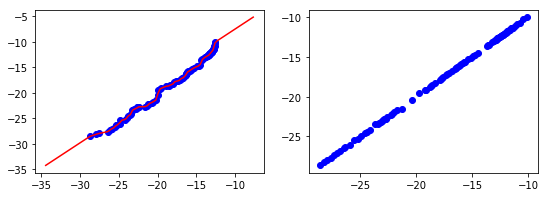

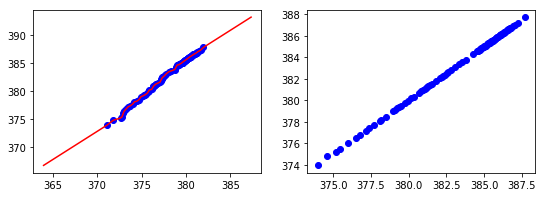

In [114]:
# Here we call the QQ mapping routine. [Note that this comes from GeneralFunctions]

# First we test the correction to illustrate the treatment
## Temp 
fig,ax=plt.subplots(1,2); fig.set_size_inches(9,3)
### Demo
test=np.linspace(np.min(comb["t"])-5,np.max(comb["t"])+5,500)
demoCorr=GF.QQmatch3(comb["Temp_Obs"],comb["t"],pcs,test,extrap=False)
ax.flat[0].plot(np.percentile(test,pcs),np.percentile(demoCorr,pcs),color="r")
ax.flat[0].scatter(qs["t"],qs["Temp_Obs"],color="b")
### Correct overlapping period
testCorr=GF.QQmatch3(comb["Temp_Obs"],comb["t"],pcs,comb["t"],extrap=False)
ax.flat[1].scatter(np.percentile(testCorr,pcs),qs["Temp_Obs"],color="b")


## Press
fig,ax=plt.subplots(1,2);fig.set_size_inches(9,3)
### Demo
test=np.linspace(np.min(comb["level"])-5,np.max(comb["level"])+5,500)
testCorr=GF.QQmatch3(comb["Press_Obs"],comb["level"],pcs,test,extrap=False)
ax.flat[0].plot(np.percentile(test,pcs),np.percentile(testCorr,pcs),color="r")
ax.flat[0].scatter(qs["level"],qs["Press_Obs"],color="b")
### Correct overlapping period
testCorr=GF.QQmatch3(comb["Press_Obs"],comb["level"],pcs,comb["level"],extrap=False)
ax.flat[1].scatter(np.percentile(testCorr,pcs),qs["Press_Obs"],color="b")

# Correct the entire period and add to mod_daily
## Temp
mod_daily["t_corr"]=GF.QQmatch3(comb["Temp_Obs"],comb["t"],pcs,mod_daily["t"],extrap=False)
## Press
mod_daily["p_corr"]=GF.QQmatch3(comb["Press_Obs"],comb["level"],pcs,mod_daily["level"],extrap=False)



# Adjusting bias corrected data to the summit
Here we use the bias-corrected data, along with the lapse rate and hypsometric equation, to compute the summit temperature and pressure:

\begin{eqnarray}
T_s=T_c+{\Gamma}dz\\
P_s=P_ce^{-dz g/R_d\bar{T}}
\end{eqnarray}

Where $_s$ and $_c$ denote the South Col and summit, respectively. Note that $\bar{T}$ is mean virtual temperature in the layer between the South Col and the summit. Here we make the approximation that the virtual air temperature is equal to the air temperature. This simplification is reasonable because the Tv is, on average << .1% greater than T (using raw Reanalysis specific humidity at the South Col)

In [132]:


def adjustT(temp,lapse,dz):
    """
    Simple function to take an observed temperature (temp) and adjust for a change in elevation (dz) 
    using the lapse rate (lapse)
    NB: Lapse in degC or K km^-1
    """
    temp_adj=temp+lapse/1000.*dz
    
    return temp_adj

def adjustP(press,temp,lapse,dz):
    """
    Simple function using the hypsometric equation to estimate the pressure after a change in altitude of 
    dz, given starting pressure (press) and starting temp (temp)
    """
    tav=1/2.*(temp+adjustT(temp,lapse,dz))+273.15 # NB: C-->K
    g=8.80655 # gravitational acceleration
    Rd=287 # gas constant for dry air
    press_adj=press*np.exp(-dz*g/(Rd*tav))
    
    return press_adj

mod_daily["summit_temp"]=adjustT(mod_daily["t_corr"],mod_daily["lapse"],8848-7986)
mod_daily["summit_press"]=adjustP(mod_daily["p_corr"],mod_daily["t_corr"],mod_daily["lapse"],8848-7986)
# Test the factor that Tv is larger than T by...
#vp=GF.Q2vp(mod_daily["q"],mod_daily["level"])
#mod_daily["raw_mix_rat"]=0.622*vp/(mod_daily["level"]*100-vp)
#mu_mult=np.mean(1+0.61*mod_daily["raw_mix_rat"]); print mu_mult

# Computing Summit VO$_2$ Max
Now we convert summit pressure to the inspired oxygen, pI. This differs from the available oxygen (which is 20.95% of the total pressure) due to the moistening of the air when inhaled.

The conversion to VO$_2$ max is then achived by inverting the (log-linear) regression of Bailey (2001) who performed a meta-analysis of the relationship between inspired O$_2$ and VO$_2$ Max. Note that $c$ is the conversion multiplier (1.3332239) to transform mmHg to hPa

\begin{eqnarray}
pI = c \times e^{(0.0308 \times VO_2 Max + 3.2500)}\\
pI/c = e^{(0.0308 \times VO_2 Max + 3.2500)}\\
ln(pI/c)=0.0308 \times VO_2 Max + 3.2500 \\
VO_2 Max = (ln(pI/c)-3.2500)/0.0308
\end{eqnarray}

In [147]:
mod_daily["summit_pI"]=0.2095*(mod_daily["summit_press"]-GF.satVp(36.8+273.15)/100.)
mod_daily["VO2_max"]=(np.log(mod_daily["summit_pI"]/1.3332239)-3.25)/0.0308